# PROJECT SOLUTION

# TASK #1: IMPORT KEY LIBRARIES/DATASETS, PERFORM EDA AND PREPARE THE DATA FOR TRAINING

In [2]:
# Import Numpy and check the version
import numpy as np
print(np.__version__)

1.21.5


In [3]:
# Import Numpy and check the version
import pandas as pd
print(pd.__version__)

1.3.5


In [4]:
# Updgrade Numpy version
!pip3 install numpy --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [5]:
# Updgrade Pandas version
!pip3 install pandas --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # Interactive Data Visualization

In [7]:
# Read the CSV file 
stock_df = pd.read_csv("S&P500_Stock_Data.csv")

In [8]:
# Load the top 6 instances
stock_df.head(6)

,Interest Rates,Employment,S&P 500 Price
0,1.943859,55.413571,2206.680582
1,2.258229,59.546305,2486.474488
2,2.215863,57.414687,2405.868337
3,1.977960,49.908353,2140.434475
4,2.437723,52.035492,2411.275663
5,2.143637,56.060598,2187.344909


In [9]:
# Load the bottom 6 instances 
stock_df.tail(6)

,Interest Rates,Employment,S&P 500 Price
994,1.868835,60.543377,2065.424594
995,2.528420,52.390828,2578.699184
996,2.643571,54.626204,2573.865933
997,2.009644,57.004357,2004.911218
998,2.201656,62.447790,2344.098981
999,2.180638,46.297034,2156.133786


In [10]:
# Display the feature columns
stock_df.columns

Index(['Interest Rates', 'Employment', 'S&P 500 Price'], dtype='object')

In [11]:
# Check the shape of the dataframe
stock_df.shape

(1000, 3)

In [12]:
# Check if any missing values are present in the dataframe
stock_df.isnull().sum()

Interest Rates    0
Employment        0
S&P 500 Price     0
dtype: int64

In [13]:
stock_df = stock_df.dropna()

In [14]:
stock_df.dtypes

Interest Rates    float64
Employment        float64
S&P 500 Price     float64
dtype: object

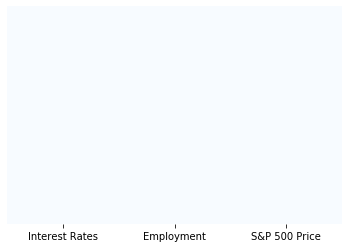

In [15]:
# check if there are any Null values
sns.heatmap(stock_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

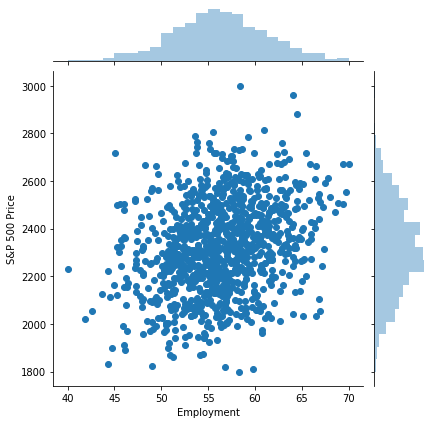

In [18]:
sns.jointplot(x = 'Employment', y = 'S&P 500 Price', data=stock_df);

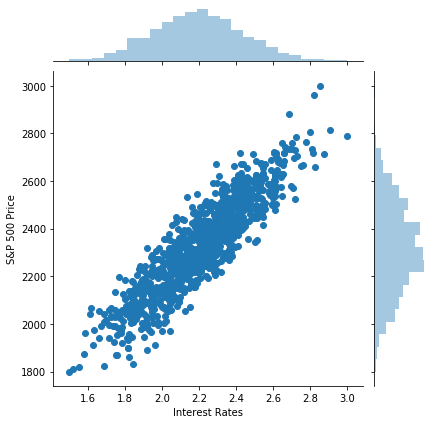

In [19]:
sns.jointplot(x = 'Interest Rates',y = 'S&P 500 Price', data = stock_df);

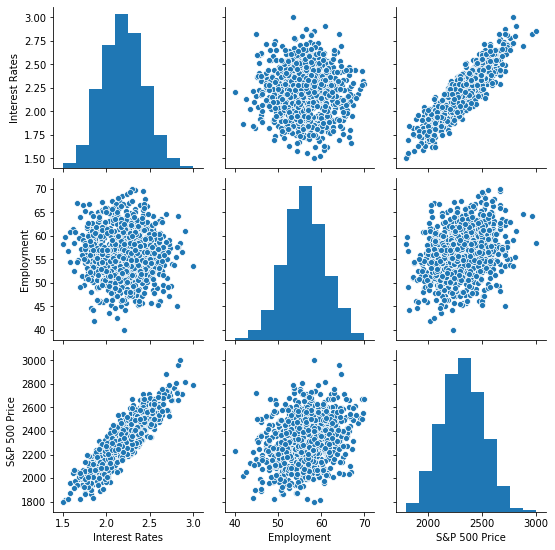

In [21]:
sns.pairplot(stock_df);

In [28]:
y = stock_df['S&P 500 Price']

In [29]:
X = stock_df[['Interest Rates', 'Employment']]

In [ ]:
# X = np.array(X)

In [ ]:
# y = np.array(y)

# TASK #3: TRAIN A LINEAR LEARNER MODEL USING SAGEMAKER TO SOLVE MULTIPLE LINEAR REGRESSION PROBLEM

In [30]:
# Convert the datatype to float32 (to run Linear Learner successfully)
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2)

In [31]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker
import boto3

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Let's define the S3 bucket and prefix that we want to use in this session
# bucket = 'aws-ml-10days' # bucket named 'aws-ml-10days' was created beforehand

bucket = sagemaker_session.default_bucket() 
prefix = 'linear_learner' # prefix is the subfolder within the bucket.

# Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3). 
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::971421653261:role/service-role/AmazonSageMaker-ExecutionRole-20220323T130903


In [32]:
X_train.shape

(800, 2)

In [33]:
y_train.shape

(800,)

In [34]:
# y_train = y_train[:,0]

In [35]:
y_train.shape

(800,)

In [36]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker Linear Learner 

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 


0

In [37]:
import os

# Code to upload RecordIO data to S3
 
# Key refers to the name of the file    
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-971421653261/linear_learner/train/linear-train-data


In [38]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-971421653261/linear_learner/output


In [39]:
# Note that this code leverages the new SageMaker SDK 2.0
# Check this for the list of changes from AWS SageMaker SDK 1.0 to 2.0: https://sagemaker.readthedocs.io/en/stable/v2.html

# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm that we want to use

# Let's obtain a reference to the linearLearner container image
# Note that all regression models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)


# This is using the old AWS SageMAker SDK 1.0 (You need to use get_image_uri and note that attribute order is different as well)
# from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [41]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)


# We can tune parameters like the number of features that we are passing in, type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them (built-in parameters optimization!)

linear.set_hyperparameters(feature_dim = 2,
                           predictor_type = 'regressor',
                           mini_batch_size = 100,
                           epochs = 100,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

2022-03-29 07:56:16 Starting - Starting the training job...
2022-03-29 07:56:21 Starting - Launching requested ML instancesProfilerReport-1648540575: InProgress
.........
2022-03-29 07:58:15 Starting - Preparing the instances for training.........
2022-03-29 07:59:39 Downloading - Downloading input data
2022-03-29 07:59:39 Training - Downloading the training image...
2022-03-29 08:00:16 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/29/2022 08:00:12 INFO 139924766533440] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method'

# TASK #4: DEPLOY AND TEST THE TRAINED LINEAR LEARNER MODEL 

In [42]:
# Deploying the model to perform inference 

# Content type overrides the data that will be passed to the deployed model, since the deployed model expects data in text/csv format.
# Serializer accepts a single argument, the input data, and returns a sequence of bytes in the specified content type
# Deserializer accepts two arguments, the result data and the response content type, and return a sequence of bytes in the specified content type.

from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer


linear_regressor = linear.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge',
                                 serializer=CSVSerializer(),
                                 deserializer=JSONDeserializer())

-----------!

In [43]:
# making prediction on the test data

result = linear_regressor.predict(X_test)

In [44]:
result # results are in Json format

{'predictions': [{'score': 2211.78173828125},
  {'score': 2422.698486328125},
  {'score': 2337.44287109375},
  {'score': 2128.30078125},
  {'score': 2165.56640625},
  {'score': 2294.447265625},
  {'score': 2634.07763671875},
  {'score': 2416.66259765625},
  {'score': 2245.1279296875},
  {'score': 2392.949951171875},
  {'score': 2107.03125},
  {'score': 2450.669921875},
  {'score': 2076.46630859375},
  {'score': 2295.769775390625},
  {'score': 2576.876708984375},
  {'score': 2490.7958984375},
  {'score': 2380.35888671875},
  {'score': 2488.2353515625},
  {'score': 2363.646240234375},
  {'score': 2074.602783203125},
  {'score': 2273.53662109375},
  {'score': 2272.642333984375},
  {'score': 2246.6318359375},
  {'score': 2609.841552734375},
  {'score': 1869.236572265625},
  {'score': 2186.917724609375},
  {'score': 2026.1297607421875},
  {'score': 2759.10205078125},
  {'score': 2348.37548828125},
  {'score': 2354.6513671875},
  {'score': 2208.462646484375},
  {'score': 2295.28759765625},
 

In [45]:
# Since the result is in json format, we access the scores by iterating through the scores in the predictions

predictions = np.array([r['score'] for r in result['predictions']])

In [46]:
predictions

array([2211.78173828, 2422.69848633, 2337.44287109, 2128.30078125,
       2165.56640625, 2294.44726562, 2634.07763672, 2416.66259766,
       2245.12792969, 2392.94995117, 2107.03125   , 2450.66992188,
       2076.46630859, 2295.76977539, 2576.87670898, 2490.79589844,
       2380.35888672, 2488.23535156, 2363.64624023, 2074.6027832 ,
       2273.53662109, 2272.64233398, 2246.63183594, 2609.84155273,
       1869.23657227, 2186.91772461, 2026.12976074, 2759.10205078,
       2348.37548828, 2354.65136719, 2208.46264648, 2295.28759766,
       2343.14038086, 2207.20825195, 2109.67407227, 2847.90307617,
       2177.49609375, 2343.2421875 , 2293.83178711, 2089.78735352,
       2063.45898438, 2224.9284668 , 1871.78100586, 2421.08496094,
       2051.18994141, 2050.60791016, 2257.27832031, 2196.62158203,
       2606.27636719, 2404.71264648, 2546.54125977, 2238.34765625,
       2360.63696289, 2376.25292969, 2389.54052734, 2464.17529297,
       2374.3359375 , 2434.40258789, 2401.17773438, 2465.12695

In [47]:
predictions.shape

(200,)

In [48]:
y_test.shape

(200,)

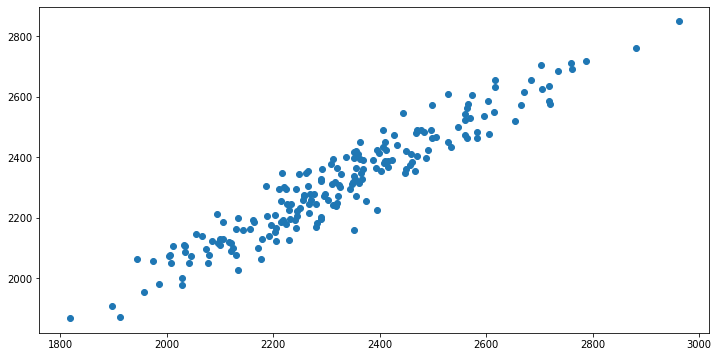

In [49]:
# Visualize how accurate predictions are relative to y_test
plt.figure(figsize = (12, 6))
plt.scatter(y_test, predictions)

In [50]:
# Delete the end-point
linear_regressor.delete_endpoint()

# EXCELLENT JOB!